In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees


/n/home04/cfang/.conda/envs/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Model

In [2]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "lazyload"
env_name = "tree_layers7_bprob0.9_envs600000_H800_explore"
model_name = "transformer_end_query_embd512_layer4_head4_lr0.0001_drop0.1_batch256"
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
ckpt_name = find_ckpt_file(model_path, "best")
path_to_pkl = os.path.join(model_path, ckpt_name)

In [3]:
model_config = {
    "n_embd": 512,
    "n_layer": 4,
    "n_head": 4,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": 0.1,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [4]:
from src.models.transformer_end_query import Transformer
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')


/tmp/ipykernel_2623050/3170755486.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [22]:
eval_dataset_path = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/lazyload/tree_layers7_bprob1.0_envs600000_H1600_explore/datasets/eval.h5"
eval_trajs = h5py.File(eval_dataset_path, 'r')
traj_indices = list(eval_trajs.keys())
n_eval_envs = min(50, len(traj_indices))
random.seed(0)
traj_indices = random.sample(traj_indices, n_eval_envs)
random.seed()
eval_trajs = [eval_trajs[i] for i in traj_indices]


In [24]:
eval_config = {
    'offline_eval_episodes': 1,
    'horizon': 400,
    'n_eval_envs': 5,
    'max_layers': 7,
    'branching_prob': 1.0,
    'node_encoding': 'random',
}
eval_func = EvalTrees()

Running offline evaluations
Resetting all environments
Resetting all environments
Resetting all environments
Epsgreedy returns: [0. 0. 0. 0. 0.]
Greedy returns: [0. 0. 0. 0. 0.]



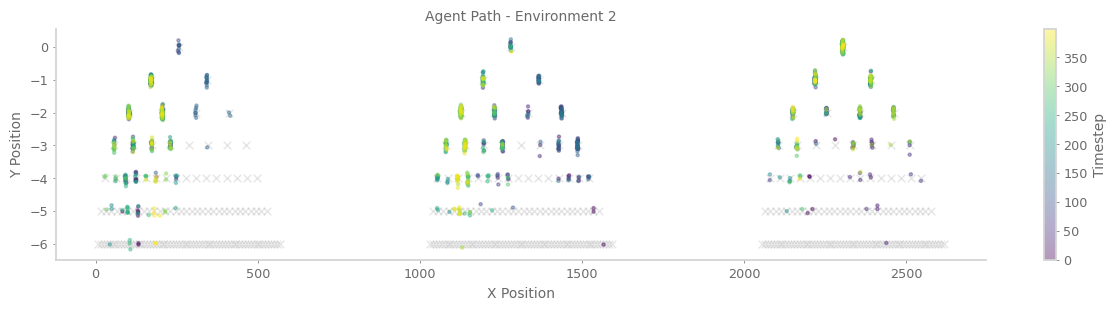

Running offline evaluations
Resetting all environments
Resetting all environments
Resetting all environments
Epsgreedy returns: [  0.   0.   0.   0. 387.]
Greedy returns: [0. 0. 0. 0. 0.]



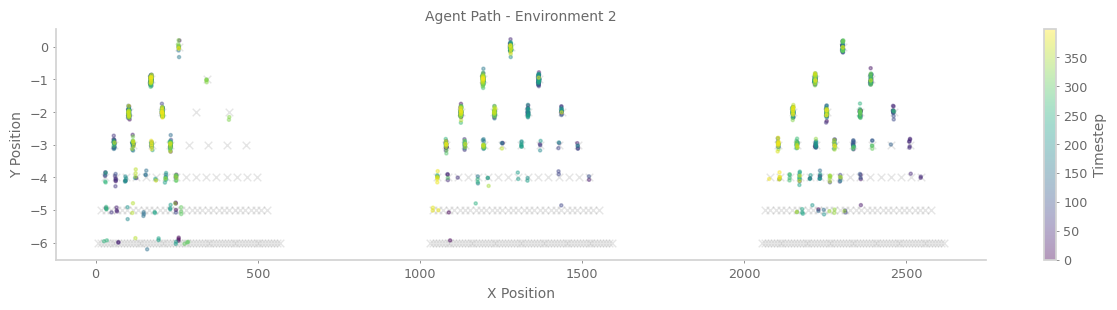

Running offline evaluations
Resetting all environments
Resetting all environments
Resetting all environments
Epsgreedy returns: [281.   0.   0. 359. 383.]
Greedy returns: [  0.   0.   0.   0. 389.]



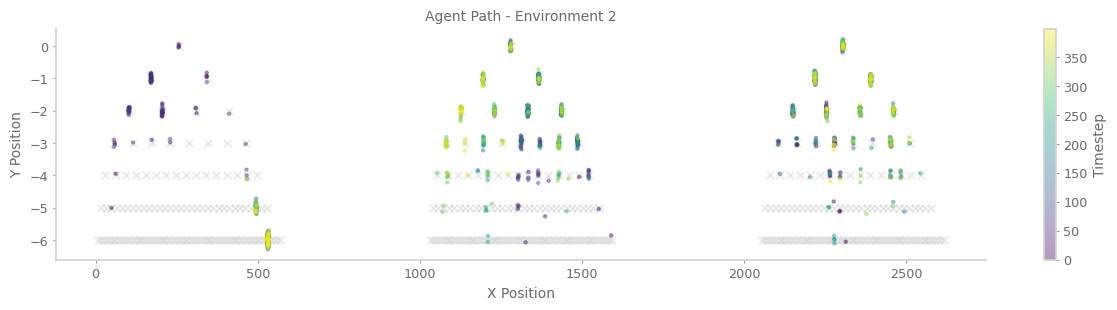

Running offline evaluations
Resetting all environments
Resetting all environments
Resetting all environments
Epsgreedy returns: [385. 385.   0. 362. 389.]
Greedy returns: [389. 389.   0.   0. 389.]



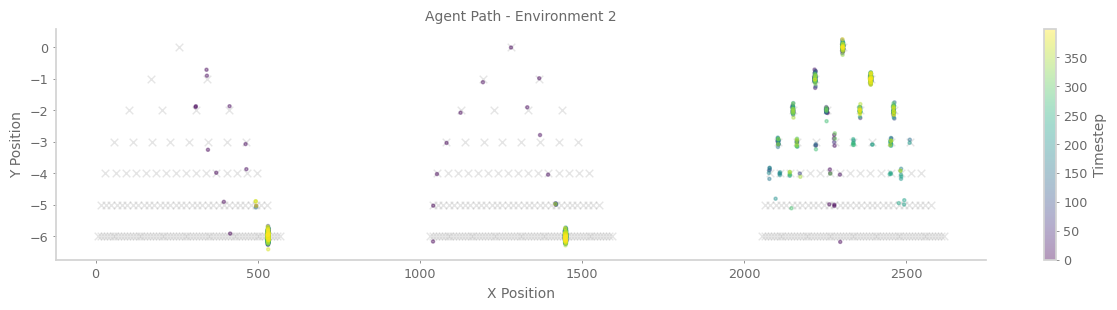

In [25]:
eval_idx_start = 10
eval_idx_end = eval_idx_start + eval_config['n_eval_envs']
unformatted_trajs = eval_trajs[eval_idx_start:eval_idx_end]

for context_length in [1, 200, 300, 1000]:
    trajs = []
    for traj in unformatted_trajs:
        _traj = {}
        for k in traj.keys():
            if 'context' in k:
                val = traj[k][:context_length]
            elif k == 'initialization_seed':
                val = np.array(traj[k]).item()
            elif k == 'goal':
                val = np.array(traj[k])
            else:  # optimal_action and query_state shouldn't be needed in eval
    
                val = traj[k]
            _traj[k] = val
        trajs.append(_traj)
    
    _returns, _obs, _envs = eval_func.offline(trajs, model, eval_config, return_envs=True)
    
    fig, ax = plt.subplots(figsize=(15, 3))
    eval_func.plot_trajectory(_obs, _envs, ax)
    plt.show()
